In [1]:
# prerequisites
import os
import torch
import time
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from tqdm import tqdm

from utils import *
from models import MNIST_Generator, MNIST_SITE

# Device configuration
torch.manual_seed(0)
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [2]:
batch_size = 256
model_path = './models/MNIST'
n_epoch = 200
n_show = 1

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=batch_size, shuffle=False)

In [3]:
site = MNIST_SITE().to(device)
print(f'Models are properly built! There are totally {get_n_params(site)} parameters.')

optimizer = optim.Adam(site.parameters(), lr = 1e-3)

celoss = nn.CrossEntropyLoss()
bceloss = nn.BCELoss()

Models are properly built! There are totally 1365472 parameters.


235it [00:13, 17.19it/s]


epoch: 1, loss: 1.237/7.443, train_acc: 0.6097, test_acc: 0.8070, time: 15.23


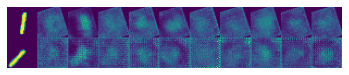

235it [00:13, 17.67it/s]


epoch: 2, loss: 0.533/6.375, train_acc: 0.8397, test_acc: 0.8700, time: 14.83


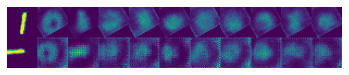

235it [00:14, 16.41it/s]


epoch: 3, loss: 0.409/6.140, train_acc: 0.8783, test_acc: 0.8851, time: 15.93


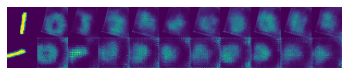

235it [00:14, 16.35it/s]


epoch: 4, loss: 0.339/6.032, train_acc: 0.8990, test_acc: 0.9184, time: 15.93


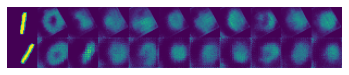

235it [00:13, 17.59it/s]


epoch: 5, loss: 0.296/5.959, train_acc: 0.9124, test_acc: 0.8995, time: 14.91


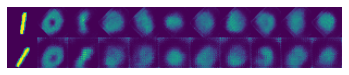

235it [00:13, 16.98it/s]


epoch: 6, loss: 0.279/5.920, train_acc: 0.9187, test_acc: 0.9214, time: 15.45


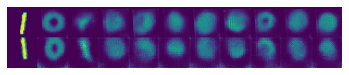

235it [00:14, 16.23it/s]


epoch: 7, loss: 0.260/5.895, train_acc: 0.9221, test_acc: 0.9313, time: 16.01


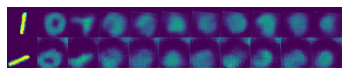

235it [00:13, 17.39it/s]


epoch: 8, loss: 0.237/5.808, train_acc: 0.9297, test_acc: 0.9376, time: 15.06


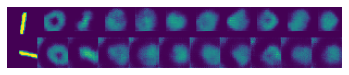

235it [00:14, 16.11it/s]


epoch: 9, loss: 0.226/5.859, train_acc: 0.9327, test_acc: 0.9372, time: 16.17


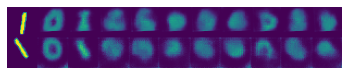

235it [00:13, 16.79it/s]


epoch: 10, loss: 0.217/5.846, train_acc: 0.9348, test_acc: 0.9446, time: 15.61


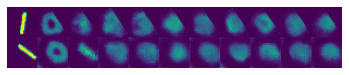

235it [00:13, 17.05it/s]


epoch: 11, loss: 0.216/5.841, train_acc: 0.9371, test_acc: 0.9450, time: 15.38


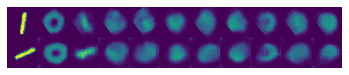

235it [00:14, 16.69it/s]


epoch: 12, loss: 0.200/5.810, train_acc: 0.9404, test_acc: 0.9470, time: 15.65


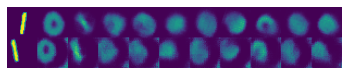

235it [00:13, 16.92it/s]


epoch: 13, loss: 0.195/5.862, train_acc: 0.9426, test_acc: 0.9486, time: 15.54


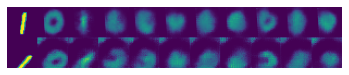

235it [00:13, 17.04it/s]


epoch: 14, loss: 0.194/5.848, train_acc: 0.9439, test_acc: 0.9528, time: 15.33


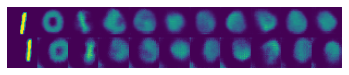

235it [00:13, 17.13it/s]


epoch: 15, loss: 0.183/5.869, train_acc: 0.9463, test_acc: 0.9493, time: 15.30


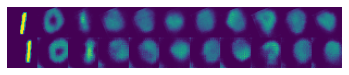

235it [00:14, 16.46it/s]


epoch: 16, loss: 0.184/5.835, train_acc: 0.9461, test_acc: 0.9529, time: 15.87


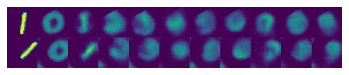

235it [00:14, 16.51it/s]


epoch: 17, loss: 0.174/5.784, train_acc: 0.9491, test_acc: 0.9496, time: 15.76


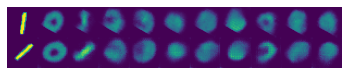

235it [00:13, 17.50it/s]


epoch: 18, loss: 0.175/5.812, train_acc: 0.9481, test_acc: 0.9517, time: 15.05


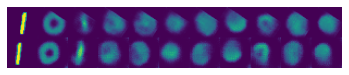

235it [00:13, 17.05it/s]


epoch: 19, loss: 0.174/5.821, train_acc: 0.9488, test_acc: 0.9493, time: 15.36


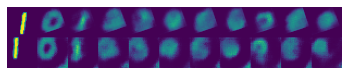

235it [00:13, 16.80it/s]


epoch: 20, loss: 0.169/5.795, train_acc: 0.9516, test_acc: 0.9581, time: 15.57


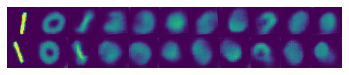

235it [00:14, 16.74it/s]


epoch: 21, loss: 0.161/5.856, train_acc: 0.9528, test_acc: 0.9582, time: 15.63


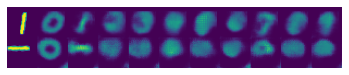

235it [00:13, 16.87it/s]


epoch: 22, loss: 0.162/5.784, train_acc: 0.9526, test_acc: 0.9600, time: 15.54


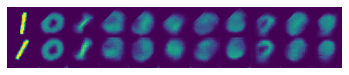

235it [00:14, 16.30it/s]


epoch: 23, loss: 0.160/5.786, train_acc: 0.9531, test_acc: 0.9544, time: 15.98


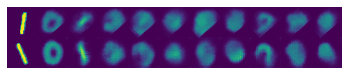

235it [00:13, 17.19it/s]


epoch: 24, loss: 0.158/5.801, train_acc: 0.9537, test_acc: 0.9604, time: 15.21


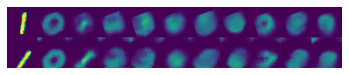

235it [00:13, 16.79it/s]


epoch: 25, loss: 0.157/5.792, train_acc: 0.9538, test_acc: 0.9570, time: 15.65


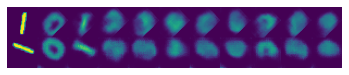

235it [00:13, 17.83it/s]


epoch: 26, loss: 0.156/5.815, train_acc: 0.9541, test_acc: 0.9620, time: 14.75


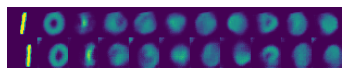

235it [00:14, 16.75it/s]


epoch: 27, loss: 0.152/5.807, train_acc: 0.9556, test_acc: 0.9607, time: 15.61


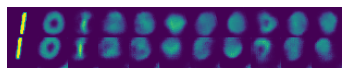

235it [00:13, 16.86it/s]


epoch: 28, loss: 0.146/5.732, train_acc: 0.9572, test_acc: 0.9619, time: 15.59


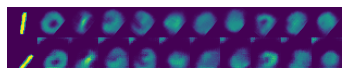

235it [00:14, 16.69it/s]


epoch: 29, loss: 0.145/5.774, train_acc: 0.9579, test_acc: 0.9627, time: 15.66


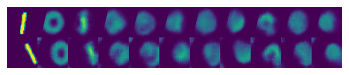

235it [00:13, 16.92it/s]


epoch: 30, loss: 0.139/5.771, train_acc: 0.9590, test_acc: 0.9598, time: 15.47


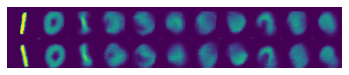

235it [00:13, 16.87it/s]


epoch: 31, loss: 0.140/5.757, train_acc: 0.9590, test_acc: 0.9641, time: 15.51


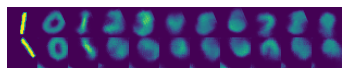

235it [00:13, 17.16it/s]


epoch: 32, loss: 0.143/5.806, train_acc: 0.9589, test_acc: 0.9597, time: 15.28


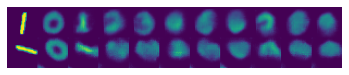

235it [00:14, 16.57it/s]


epoch: 33, loss: 0.141/5.799, train_acc: 0.9594, test_acc: 0.9636, time: 15.74


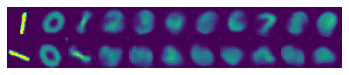

235it [00:14, 16.68it/s]


epoch: 34, loss: 0.142/5.780, train_acc: 0.9589, test_acc: 0.9658, time: 15.69


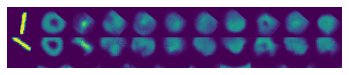

235it [00:13, 17.43it/s]


epoch: 35, loss: 0.136/5.754, train_acc: 0.9600, test_acc: 0.9592, time: 15.05


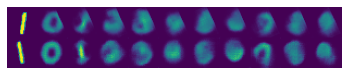

235it [00:13, 17.20it/s]


epoch: 36, loss: 0.134/5.720, train_acc: 0.9606, test_acc: 0.9609, time: 15.25


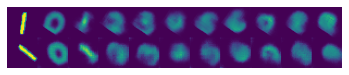

235it [00:14, 16.02it/s]


epoch: 37, loss: 0.132/5.734, train_acc: 0.9617, test_acc: 0.9631, time: 16.26


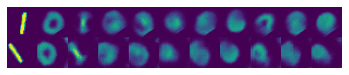

235it [00:14, 16.68it/s]


epoch: 38, loss: 0.135/5.755, train_acc: 0.9608, test_acc: 0.9611, time: 15.72


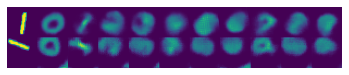

235it [00:14, 16.76it/s]


epoch: 39, loss: 0.132/5.773, train_acc: 0.9616, test_acc: 0.9664, time: 15.64


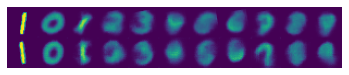

235it [00:14, 16.63it/s]


epoch: 40, loss: 0.131/5.750, train_acc: 0.9607, test_acc: 0.9608, time: 15.76


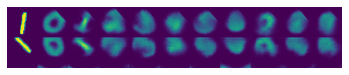

235it [00:13, 16.86it/s]


epoch: 41, loss: 0.128/5.763, train_acc: 0.9625, test_acc: 0.9691, time: 15.54


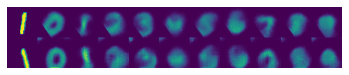

235it [00:14, 16.54it/s]


epoch: 42, loss: 0.126/5.722, train_acc: 0.9630, test_acc: 0.9668, time: 15.79


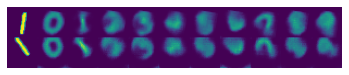

235it [00:14, 16.09it/s]


epoch: 43, loss: 0.125/5.722, train_acc: 0.9627, test_acc: 0.9660, time: 16.24


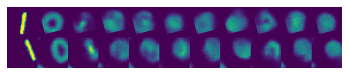

235it [00:13, 17.09it/s]


epoch: 44, loss: 0.124/5.760, train_acc: 0.9638, test_acc: 0.9674, time: 15.31


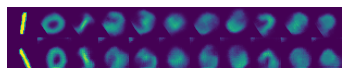

235it [00:13, 17.43it/s]


epoch: 45, loss: 0.123/5.729, train_acc: 0.9652, test_acc: 0.9672, time: 15.06


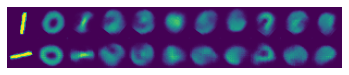

235it [00:13, 17.17it/s]


epoch: 46, loss: 0.119/5.728, train_acc: 0.9654, test_acc: 0.9694, time: 15.30


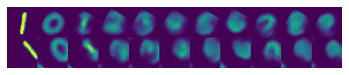

235it [00:13, 17.36it/s]


epoch: 47, loss: 0.120/5.751, train_acc: 0.9646, test_acc: 0.9643, time: 15.13


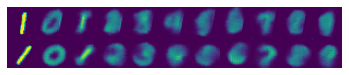

235it [00:13, 17.58it/s]


epoch: 48, loss: 0.118/5.752, train_acc: 0.9652, test_acc: 0.9691, time: 14.94


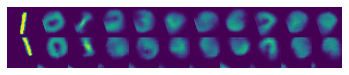

235it [00:14, 16.78it/s]


epoch: 49, loss: 0.119/5.743, train_acc: 0.9659, test_acc: 0.9696, time: 15.63


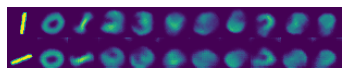

235it [00:13, 16.87it/s]


epoch: 50, loss: 0.120/5.741, train_acc: 0.9647, test_acc: 0.9710, time: 15.50


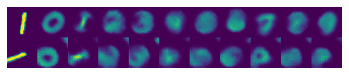

235it [00:14, 16.76it/s]


epoch: 51, loss: 0.119/5.746, train_acc: 0.9653, test_acc: 0.9705, time: 15.63


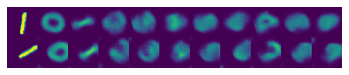

235it [00:13, 17.03it/s]


epoch: 52, loss: 0.118/5.751, train_acc: 0.9662, test_acc: 0.9679, time: 15.42


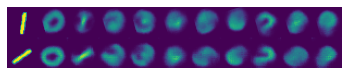

235it [00:13, 17.14it/s]


epoch: 53, loss: 0.114/5.753, train_acc: 0.9665, test_acc: 0.9706, time: 15.31


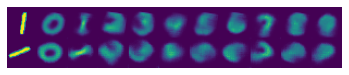

235it [00:13, 17.29it/s]


epoch: 54, loss: 0.112/5.736, train_acc: 0.9671, test_acc: 0.9685, time: 15.14


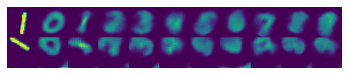

235it [00:13, 17.29it/s]


epoch: 55, loss: 0.113/5.714, train_acc: 0.9665, test_acc: 0.9675, time: 15.23


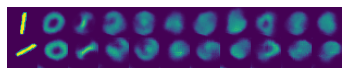

235it [00:14, 16.62it/s]


epoch: 56, loss: 0.114/5.761, train_acc: 0.9664, test_acc: 0.9644, time: 15.71


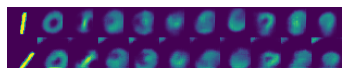

235it [00:13, 17.03it/s]


epoch: 57, loss: 0.115/5.731, train_acc: 0.9658, test_acc: 0.9696, time: 15.35


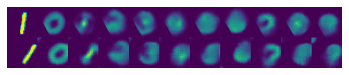

235it [00:13, 17.55it/s]


epoch: 58, loss: 0.113/5.747, train_acc: 0.9671, test_acc: 0.9681, time: 14.99


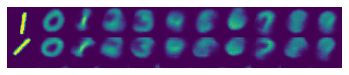

235it [00:14, 15.82it/s]


epoch: 59, loss: 0.108/5.756, train_acc: 0.9679, test_acc: 0.9720, time: 16.42


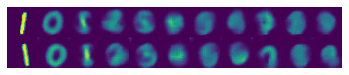

235it [00:13, 17.18it/s]


epoch: 60, loss: 0.109/5.725, train_acc: 0.9687, test_acc: 0.9685, time: 15.23


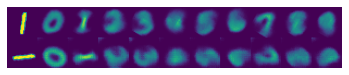

235it [00:14, 16.47it/s]


epoch: 61, loss: 0.109/5.705, train_acc: 0.9685, test_acc: 0.9680, time: 15.93


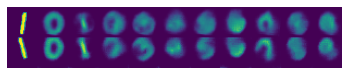

235it [00:13, 16.84it/s]


epoch: 62, loss: 0.109/5.736, train_acc: 0.9673, test_acc: 0.9709, time: 15.52


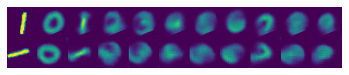

235it [00:13, 17.29it/s]


epoch: 63, loss: 0.110/5.735, train_acc: 0.9682, test_acc: 0.9721, time: 15.18


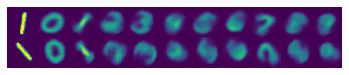

235it [00:14, 16.52it/s]


epoch: 64, loss: 0.105/5.715, train_acc: 0.9697, test_acc: 0.9709, time: 15.83


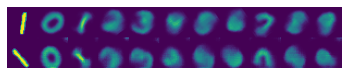

235it [00:14, 16.74it/s]


epoch: 65, loss: 0.105/5.745, train_acc: 0.9695, test_acc: 0.9721, time: 15.59


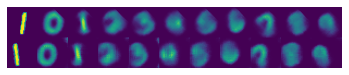

235it [00:13, 17.31it/s]


epoch: 66, loss: 0.103/5.728, train_acc: 0.9697, test_acc: 0.9710, time: 15.11


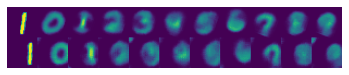

235it [00:14, 16.09it/s]


epoch: 67, loss: 0.106/5.707, train_acc: 0.9700, test_acc: 0.9707, time: 16.22


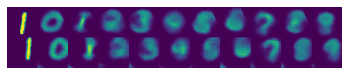

235it [00:13, 17.30it/s]


epoch: 68, loss: 0.105/5.713, train_acc: 0.9690, test_acc: 0.9704, time: 15.16


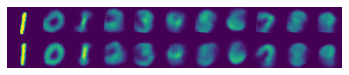

235it [00:13, 16.96it/s]


epoch: 69, loss: 0.104/5.742, train_acc: 0.9692, test_acc: 0.9701, time: 15.41


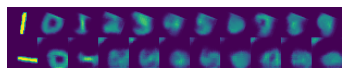

235it [00:13, 17.53it/s]


epoch: 70, loss: 0.104/5.710, train_acc: 0.9691, test_acc: 0.9751, time: 15.05


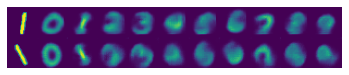

235it [00:14, 16.38it/s]


epoch: 71, loss: 0.104/5.706, train_acc: 0.9698, test_acc: 0.9740, time: 15.90


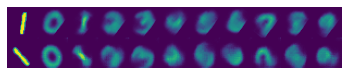

235it [00:13, 16.88it/s]


epoch: 72, loss: 0.106/5.716, train_acc: 0.9687, test_acc: 0.9726, time: 15.49


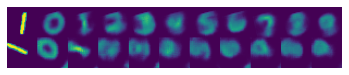

235it [00:14, 16.39it/s]


epoch: 73, loss: 0.104/5.718, train_acc: 0.9697, test_acc: 0.9725, time: 15.93


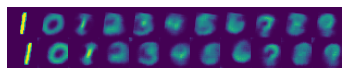

235it [00:14, 16.28it/s]


epoch: 74, loss: 0.103/5.745, train_acc: 0.9698, test_acc: 0.9715, time: 16.01


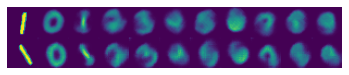

235it [00:13, 16.82it/s]


epoch: 75, loss: 0.096/5.660, train_acc: 0.9716, test_acc: 0.9750, time: 15.52


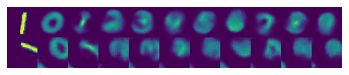

235it [00:14, 16.70it/s]


epoch: 76, loss: 0.099/5.690, train_acc: 0.9706, test_acc: 0.9736, time: 15.67


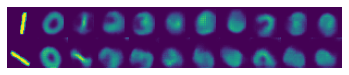

235it [00:13, 16.80it/s]


epoch: 77, loss: 0.103/5.716, train_acc: 0.9699, test_acc: 0.9730, time: 15.61


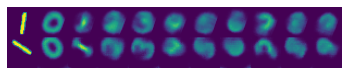

235it [00:14, 16.39it/s]


epoch: 78, loss: 0.101/5.707, train_acc: 0.9703, test_acc: 0.9738, time: 15.91


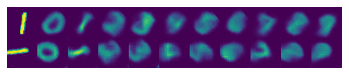

235it [00:13, 17.28it/s]


epoch: 79, loss: 0.099/5.700, train_acc: 0.9707, test_acc: 0.9728, time: 15.21


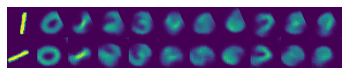

235it [00:13, 16.86it/s]


epoch: 80, loss: 0.099/5.693, train_acc: 0.9702, test_acc: 0.9708, time: 15.44


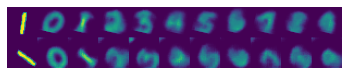

235it [00:14, 16.71it/s]


epoch: 81, loss: 0.096/5.747, train_acc: 0.9723, test_acc: 0.9730, time: 15.59


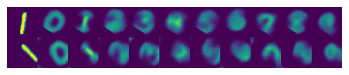

235it [00:14, 16.55it/s]


epoch: 82, loss: 0.096/5.727, train_acc: 0.9726, test_acc: 0.9745, time: 15.83


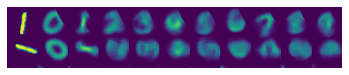

235it [00:14, 16.27it/s]


epoch: 83, loss: 0.100/5.648, train_acc: 0.9713, test_acc: 0.9705, time: 16.00


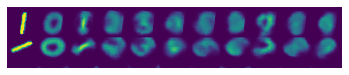

235it [00:14, 16.75it/s]


epoch: 84, loss: 0.097/5.711, train_acc: 0.9714, test_acc: 0.9715, time: 15.61


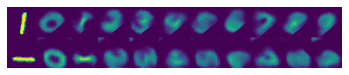

235it [00:13, 17.05it/s]


epoch: 85, loss: 0.098/5.734, train_acc: 0.9714, test_acc: 0.9746, time: 15.43


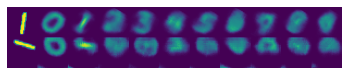

235it [00:13, 17.07it/s]


epoch: 86, loss: 0.096/5.743, train_acc: 0.9720, test_acc: 0.9720, time: 15.32


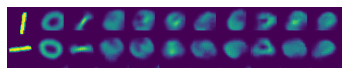

235it [00:14, 16.76it/s]


epoch: 87, loss: 0.093/5.748, train_acc: 0.9731, test_acc: 0.9711, time: 15.58


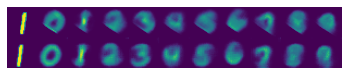

235it [00:14, 16.55it/s]


epoch: 88, loss: 0.094/5.701, train_acc: 0.9725, test_acc: 0.9766, time: 15.81


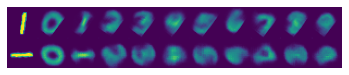

235it [00:13, 17.03it/s]


epoch: 89, loss: 0.094/5.774, train_acc: 0.9725, test_acc: 0.9718, time: 15.38


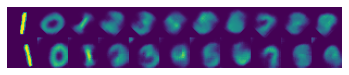

235it [00:14, 16.05it/s]


epoch: 90, loss: 0.096/5.700, train_acc: 0.9719, test_acc: 0.9740, time: 16.20


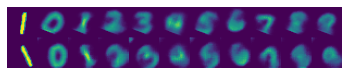

235it [00:14, 16.07it/s]


epoch: 91, loss: 0.100/5.757, train_acc: 0.9712, test_acc: 0.9729, time: 16.29


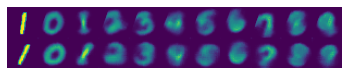

235it [00:14, 16.73it/s]


epoch: 92, loss: 0.092/5.709, train_acc: 0.9718, test_acc: 0.9745, time: 15.61


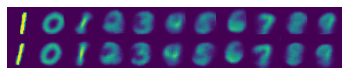

235it [00:13, 16.96it/s]


epoch: 93, loss: 0.094/5.712, train_acc: 0.9718, test_acc: 0.9741, time: 15.48


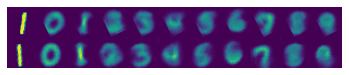

235it [00:14, 16.70it/s]


epoch: 94, loss: 0.094/5.670, train_acc: 0.9725, test_acc: 0.9733, time: 15.71


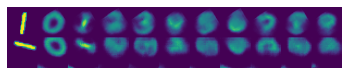

235it [00:14, 16.51it/s]


epoch: 95, loss: 0.096/5.673, train_acc: 0.9719, test_acc: 0.9734, time: 15.83


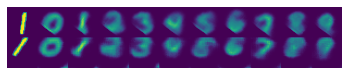

235it [00:14, 16.06it/s]


epoch: 96, loss: 0.092/5.671, train_acc: 0.9725, test_acc: 0.9742, time: 16.23


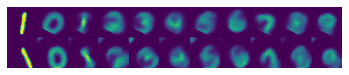

235it [00:14, 15.85it/s]


epoch: 97, loss: 0.093/5.678, train_acc: 0.9728, test_acc: 0.9734, time: 16.48


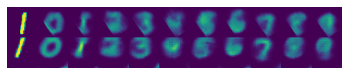

235it [00:13, 17.46it/s]


epoch: 98, loss: 0.096/5.684, train_acc: 0.9720, test_acc: 0.9756, time: 15.04


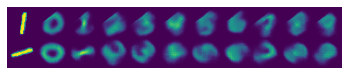

235it [00:13, 17.06it/s]


epoch: 99, loss: 0.092/5.701, train_acc: 0.9737, test_acc: 0.9735, time: 15.38


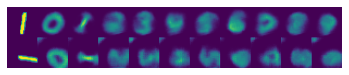

235it [00:13, 17.30it/s]


epoch: 100, loss: 0.094/5.709, train_acc: 0.9729, test_acc: 0.9732, time: 15.16


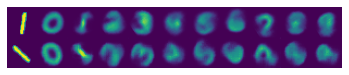

235it [00:14, 16.65it/s]


epoch: 101, loss: 0.089/5.657, train_acc: 0.9730, test_acc: 0.9745, time: 15.73


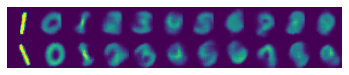

235it [00:14, 15.81it/s]


epoch: 102, loss: 0.092/5.709, train_acc: 0.9735, test_acc: 0.9704, time: 16.48


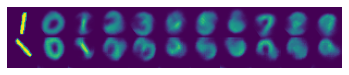

235it [00:14, 16.34it/s]


epoch: 103, loss: 0.093/5.718, train_acc: 0.9726, test_acc: 0.9752, time: 16.00


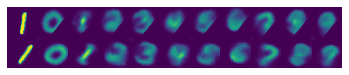

235it [00:14, 16.38it/s]


epoch: 104, loss: 0.091/5.701, train_acc: 0.9729, test_acc: 0.9741, time: 15.92


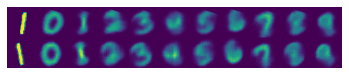

235it [00:13, 17.28it/s]


epoch: 105, loss: 0.092/5.669, train_acc: 0.9734, test_acc: 0.9740, time: 15.20


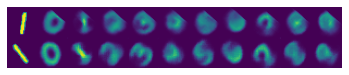

235it [00:13, 17.14it/s]


epoch: 106, loss: 0.088/5.696, train_acc: 0.9740, test_acc: 0.9761, time: 15.50


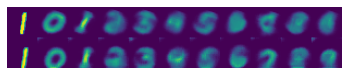

235it [00:14, 16.58it/s]


epoch: 107, loss: 0.091/5.678, train_acc: 0.9741, test_acc: 0.9738, time: 15.85


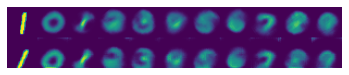

235it [00:14, 16.52it/s]


epoch: 108, loss: 0.087/5.676, train_acc: 0.9743, test_acc: 0.9756, time: 15.78


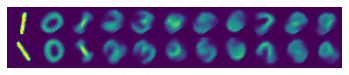

235it [00:14, 16.57it/s]


epoch: 109, loss: 0.087/5.699, train_acc: 0.9743, test_acc: 0.9752, time: 15.87


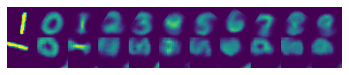

235it [00:14, 16.74it/s]


epoch: 110, loss: 0.086/5.707, train_acc: 0.9746, test_acc: 0.9760, time: 15.64


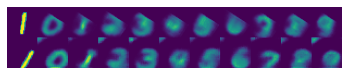

235it [00:14, 16.59it/s]


epoch: 111, loss: 0.089/5.683, train_acc: 0.9741, test_acc: 0.9748, time: 15.71


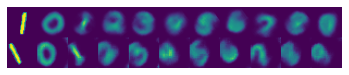

235it [00:14, 16.63it/s]


epoch: 112, loss: 0.086/5.677, train_acc: 0.9752, test_acc: 0.9728, time: 15.75


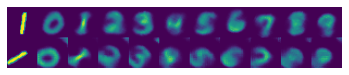

235it [00:13, 16.85it/s]


epoch: 113, loss: 0.089/5.687, train_acc: 0.9749, test_acc: 0.9768, time: 15.50


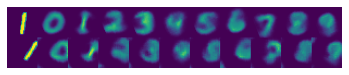

235it [00:14, 16.64it/s]


epoch: 114, loss: 0.089/5.664, train_acc: 0.9736, test_acc: 0.9745, time: 15.73


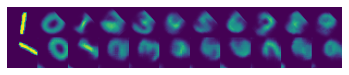

235it [00:14, 16.57it/s]


epoch: 115, loss: 0.086/5.684, train_acc: 0.9748, test_acc: 0.9752, time: 15.79


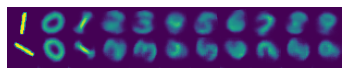

235it [00:13, 17.41it/s]


epoch: 116, loss: 0.086/5.703, train_acc: 0.9747, test_acc: 0.9744, time: 15.05


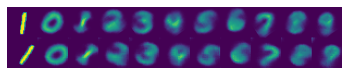

235it [00:14, 16.50it/s]


epoch: 117, loss: 0.084/5.699, train_acc: 0.9754, test_acc: 0.9747, time: 15.79


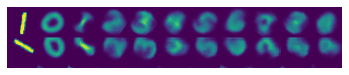

235it [00:13, 17.28it/s]


epoch: 118, loss: 0.087/5.713, train_acc: 0.9749, test_acc: 0.9764, time: 15.21


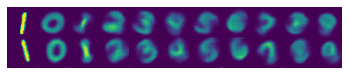

235it [00:14, 16.27it/s]


epoch: 119, loss: 0.084/5.699, train_acc: 0.9750, test_acc: 0.9763, time: 16.02


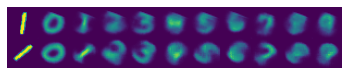

235it [00:13, 17.06it/s]


epoch: 120, loss: 0.090/5.672, train_acc: 0.9736, test_acc: 0.9740, time: 15.34


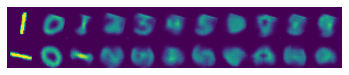

235it [00:14, 16.73it/s]


epoch: 121, loss: 0.083/5.700, train_acc: 0.9750, test_acc: 0.9780, time: 15.70


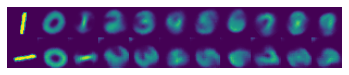

235it [00:14, 16.13it/s]


epoch: 122, loss: 0.083/5.623, train_acc: 0.9758, test_acc: 0.9743, time: 16.23


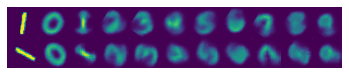

235it [00:13, 17.27it/s]


epoch: 123, loss: 0.086/5.651, train_acc: 0.9744, test_acc: 0.9793, time: 15.18


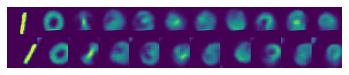

235it [00:14, 16.56it/s]


epoch: 124, loss: 0.084/5.685, train_acc: 0.9753, test_acc: 0.9764, time: 15.78


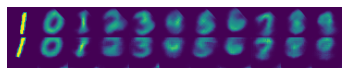

235it [00:14, 16.21it/s]


epoch: 125, loss: 0.086/5.709, train_acc: 0.9752, test_acc: 0.9783, time: 16.07


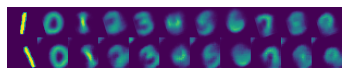

6it [00:00, 18.11it/s]

In [ ]:
for epoch in range(n_epoch):
    Loss_cls = []
    Loss_rec = []
    Loss_tar = []
    equality = 0
    start = time.time()
    
    # generate new prototypes
    prototype = get_prototype(train_loader)
    
    for batch_idx, (image, label) in tqdm(enumerate(train_loader)):
        
        site.train()
        
        optimizer.zero_grad()
        
        image = image.to(device)
        label = label.to(device)
        
        theta, gamma = get_theta(image.shape[0], get_reverse = True)
        t_image = transform(image, theta, dataset = 'MNIST')
        
        t_W, t_pred = site.get_explanation(t_image)
        t_W_t = transform_W(t_W, gamma, dataset = 'MNIST')
        
        # Classification loss
        loss_cls = celoss(t_pred, label)
        Loss_cls.append(loss_cls.item())
        
        # Reconstruction loss
        target = sample_prototype(prototype, label)
        loss_rec = 10*bceloss(t_W_t, target)
        Loss_rec.append(loss_rec.item())
        
        loss = loss_cls + loss_rec
        loss.backward()
        optimizer.step()
        
        equality += (t_pred.max(1)[1] == label).float().mean()
    
    train_accuracy = equality / (batch_idx + 1)
    
    equality = 0
    for batch_idx, (image, label) in enumerate(test_loader):
        
        site.eval()
        
        image = image.to(device)
        label = label.to(device)
        
        theta, gamma = get_theta(image.shape[0], get_reverse = True)
        t_image = transform(image, theta, dataset = 'MNIST')
        
        t_W, t_pred = site.get_explanation(t_image)

        equality += (t_pred.max(1)[1] == label).float().mean()
        
    test_accuracy = equality / (batch_idx + 1)
    
    print('epoch: {}, loss: {:.3f}/{:.3f}, train_acc: {:.4f}, test_acc: {:.4f}, time: {:.2f}'.format(
        epoch + 1,
        torch.FloatTensor(Loss_cls).mean(),
        torch.FloatTensor(Loss_rec).mean(),
        train_accuracy,
        test_accuracy,
        time.time() - start))
    
    if n_epoch % n_show == 0:
        toshow1 = torch.cat([image[0], t_W_t[0].view(10,28,28)], dim = 0)
        toshow2 = torch.cat([t_image[0], t_W[0]], dim = 0)
        toshow = torch.cat([toshow1, toshow2], dim = 1)
        plot_process(toshow)